In [14]:
import numpy as np
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask

from ekarus.e2e.pyramid_wfs import PyramidWFS
from ekarus.e2e.utils.zernike_coefficients import create_field_from_zernike_coefficients

In [15]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= np.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/np.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

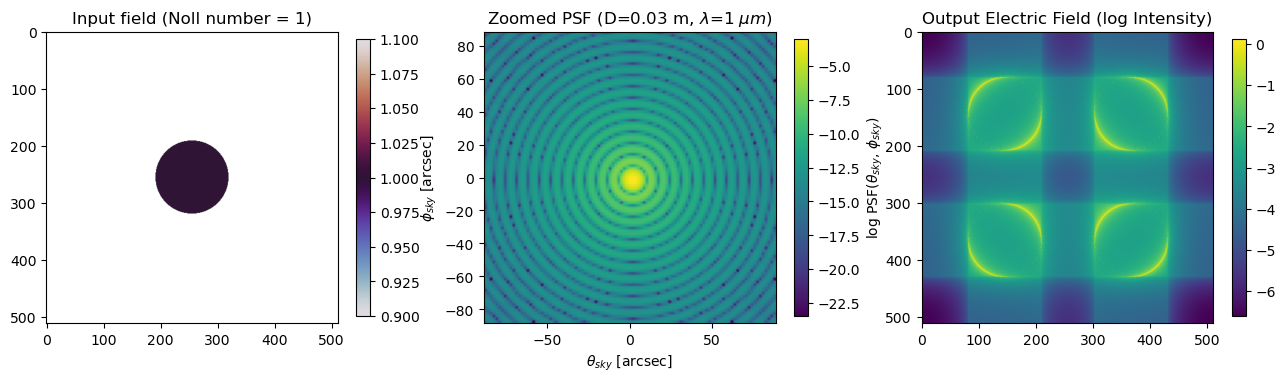

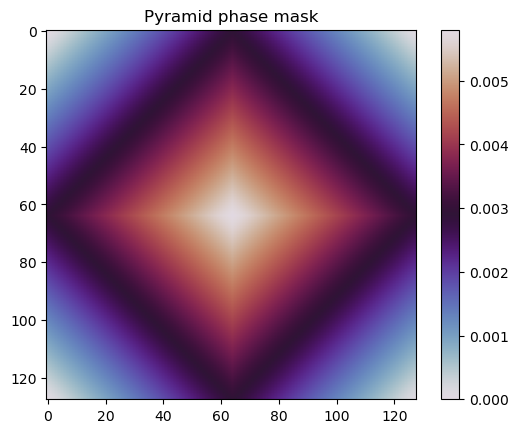

In [16]:
nx = 128

# Create pupil mask
oversampling = 4
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

# Conversions
pupilDiameterInM = 30e-3
lambdaInM = 1000e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 1
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

# Inizializzazione del sensore
apex_angle = 0.0058 # vertex angle in radians, can be tricky to find the right value
wfs = PyramidWFS(apex_angle)

# Propagazione del campo attraverso il sensore
output_field = wfs.propagate(input_field, pix2rad)
intensity = np.abs(output_field**2)

# Compute normalized psf
psf = np.abs(wfs.field_on_focal_plane**2)
psf *= 1/np.sum(psf)


# Plotting results
s = 0.45
plt.figure(1, figsize=(16,8))
plt.subplot(1, 3, 1)
plt.title(f'Input field (Noll number = {noll})')
plt.imshow(np.angle(input_field), cmap='twilight')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
showZoomCenter(psf, pix2arcsec, title=r'Zoomed PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\theta_{sky}$ [arcsec]', ylabel=r'$\phi_{sky}$ [arcsec]',
               zlabel=r'log PSF($\theta_{sky}$, $\phi_{sky}$)', shrink=0.45)
# plt.title("PSF on Focal Plane (Intensity) - Log Scale")
# plt.imshow(np.log( psf ), cmap='inferno')
# plt.colorbar(shrink=s)

plt.subplot(1, 3, 3)
plt.title("Output Electric Field (log Intensity)")
plt.imshow(np.log(intensity))
plt.colorbar(shrink=s)
plt.show()

plt.figure(2)
plt.imshow(wfs.pyramid_phase_delay((nx, nx)), cmap='twilight')
plt.title("Pyramid phase mask")
plt.colorbar()
plt.show()

(-85.94366926962348, 0) 1.7188733853924698


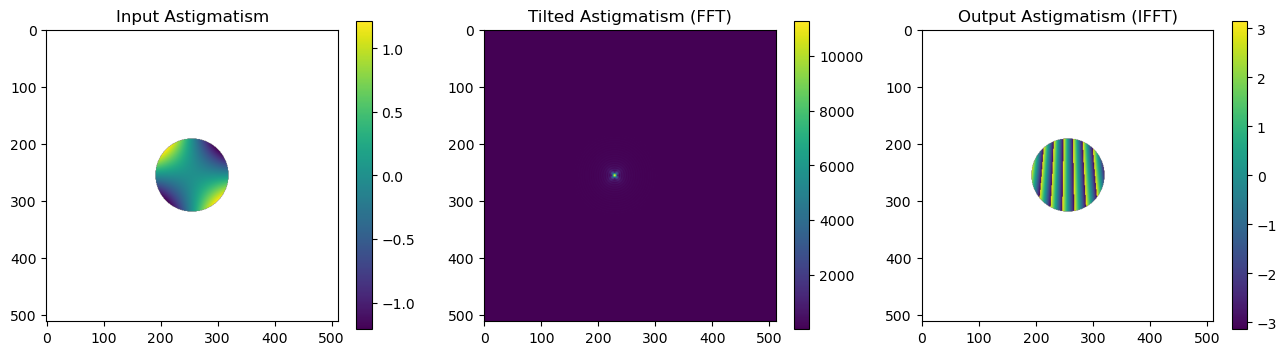

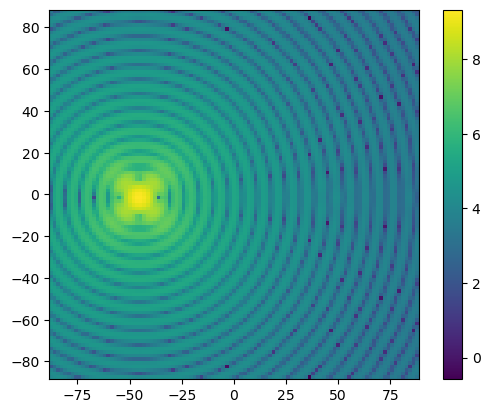

In [17]:
def generate_tilt(shape, alpha):
    ny, nx = shape
    cx, cy = nx // 2, ny // 2

    # Coordinates wrt center
    x = np.arange(nx) - cx
    y = np.arange(ny) - cy
    X, Y = np.meshgrid(x, y)

    tiltX = X/np.max(abs(X))
    tiltY = Y/np.max(abs(Y))

    alpha_x, alpha_y = alpha

    tilt = tiltX * alpha_x - tiltY * alpha_y
    #norm_tilt = (tilt-np.mean(tilt))/np.std(tilt)

    return tilt

shape = np.shape(output_field)

diameter = 30e-3
alpha = 3*lambdaInM/diameter
angle = (-50*pix2arcsec, 0)

tt = generate_tilt(shape,angle)

nx, ny = np.shape(intensity)

nx = 128
oversampling = 4
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)
input_astigmatism = create_field_from_zernike_coefficients(mask, 5, 0.5)
# fft_astigmatism = np.fft.fft2(input_astigmatism)
# fft_astigmatism = np.fft.fftshift(fft_astigmatism)

fft_tilted_astigmatism = np.fft.fftshift(np.fft.fft2(input_astigmatism*np.exp(1j*tt)))
tilted_astigmatism = np.fft.ifft2(np.fft.ifftshift(fft_tilted_astigmatism))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.title("Input Astigmatism")
plt.imshow(np.angle(input_astigmatism))
plt.colorbar(shrink=0.5)

plt.subplot(1, 3, 2)
plt.title("Tilted Astigmatism (FFT)")
plt.imshow(np.abs(fft_tilted_astigmatism))
plt.colorbar(shrink=0.5)

img = np.ma.masked_array(np.angle(tilted_astigmatism), mask=mask.mask())
plt.subplot(1, 3, 3)
plt.title("Output Astigmatism (IFFT)")
plt.imshow(img)
plt.colorbar(shrink=0.5)

plt.figure()
showZoomCenter(np.abs(fft_tilted_astigmatism), pix2arcsec)

print(angle, pix2arcsec)

96.0


(240.0, 272.0)

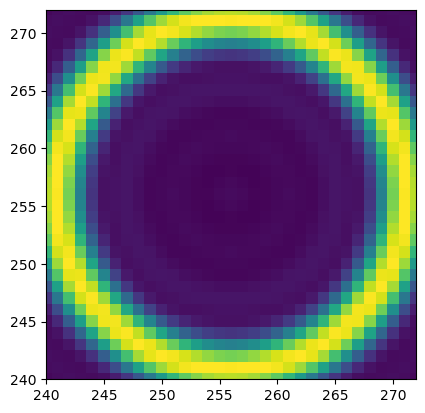

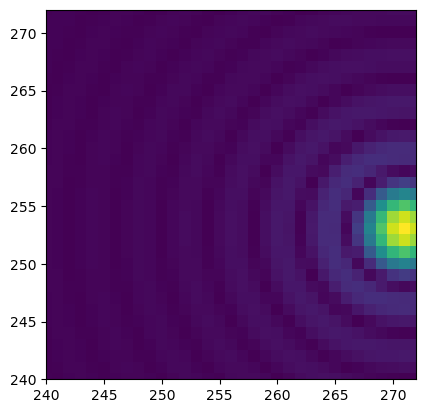

In [25]:
N_steps = 32
alpha = 6*lambdaInM/diameter*oversampling
alpha_pix = alpha/pix2rad
print(alpha_pix)

# test modulation
ny, nx = np.shape(input_field)
cx, cy = nx // 2, ny // 2

# Coordinates wrt center
x = np.arange(nx) - cx
y = np.arange(ny) - cy

# Tilt coordinates
X,Y = np.meshgrid(x, y)
# rho = np.sqrt(X**2+Y**2)
# rho *= alpha/pix2rad/np.max(np.abs(rho))
D = np.max((nx,ny))

# Number of steps for modulation (multiple of 4 for symmetry between subapertures)
phi_vec = 2*np.pi*np.arange(N_steps)/N_steps

# Initialize intensity and perform modulation
intensity = np.zeros([ny,nx])
pow_psf = np.zeros([ny,nx])

for phi in phi_vec:
    tilt = (X * np.cos(phi) + Y * np.sin(phi))/D*alpha/pix2rad
    tilted_input = input_field * np.exp(1j*tilt)

    psf = np.fft.fftshift(np.fft.fft2(tilted_input))
    pow_psf += np.abs(psf)**2

    output = wfs.propagate(tilted_input, pix2rad)
    intensity += (np.abs(output)**2)/N_steps


plt.figure()
plt.imshow(pow_psf)
plt.xlim([240,272])
plt.ylim([240,272])


plt.figure()
plt.imshow(np.abs(psf))
plt.xlim([240,272])
plt.ylim([240,272])

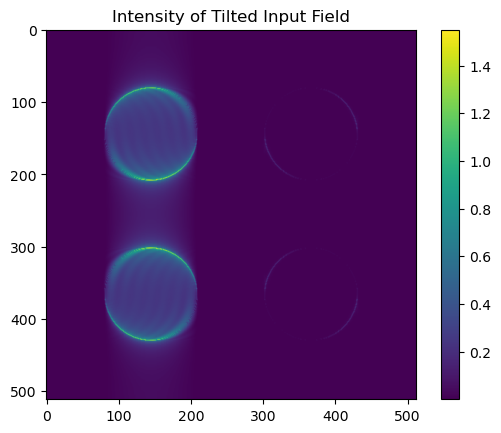

In [19]:
tilted_input = input_field *np.exp(1j*tt)
output_field = wfs.propagate(tilted_input,pix2rad)

# wfs_mod = PyramidWFS(apex_angle)
# output_field = wfs_mod.propagate(input_field)
# wfs_mod._ef_focal_plane_delayed *= np.exp(1j*tt)
# output_field = np.fft.ifft2(wfs_mod._ef_focal_plane_delayed, norm = 'ortho')

I = np.abs(output_field**2)

plt.figure()
plt.title("Intensity of Tilted Input Field")
plt.imshow(I)
plt.colorbar()
plt.show()


In [20]:
# diameter = 0.03
# alpha = 3*lambdaInM/diameter

# pix_radius = alpha/pix2arcsec*rad2arcsec

# nx, ny = np.shape(intensity)
# cx, cy = nx // 2, ny // 2

# ring = np.fromfunction(lambda x,y: np.abs(np.sqrt((x-cx)**2+(y-cy)**2)-pix_radius)<0.4,(nx,ny))

# plt.figure()
# plt.imshow(ring)
# plt.xlim([cx-20,cx+20])
# plt.ylim([cy-20,cy+20])

# fft_ring = np.fft.fft2(ring,norm = 'ortho')
# fft_ring = np.fft.fftshift(fft_ring)

# plt.figure()
# plt.imshow(np.abs(fft_ring))
# plt.colorbar()  
# plt.title("FFT of the ring")

# fft_input = np.fft.fft2(input_field, norm ='ortho')
# fft_input = np.fft.fftshift(fft_input)

# fft_conv = fft_input * fft_ring

# amplitude = np.abs(fft_conv)
# phase = np.angle(fft_conv) + wfs.pyramid_phase_delay((nx, ny))
# delayed_fft_conv = amplitude * np.exp(1j * phase)

# delayed_fft_conv = np.fft.ifftshift(delayed_fft_conv)
# output_field = np.fft.ifft2(delayed_fft_conv, norm='ortho')

# plt.figure()
# plt.imshow(np.abs(output_field)**2)
# plt.colorbar()


In [21]:
# nx = 128

# # Create pupil mask
# oversampling = 4
# mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)
# pupil = mask.mask()

# fft_pupil = np.fft.fft2(pupil,norm='ortho')
# fft_pupil = np.fft.fftshift(fft_pupil)
# delayed_fft_pupil = fft_pupil * np.exp(1j*wfs.pyramid_phase_delay(np.shape(fft_pupil)))
# out_field = np.fft.ifftshift(delayed_fft_pupil)
# out_field = np.fft.ifft2(out_field)

# out_int = (np.abs(out_field))**2

# OTF = np.fft.fft2(out_int)

# IntV = OTF * fft_ring

# Int = np.fft.ifftshift(IntV)
# Int = np.fft.ifft2(Int)

# plt.figure()
# plt.imshow(np.abs(Int))

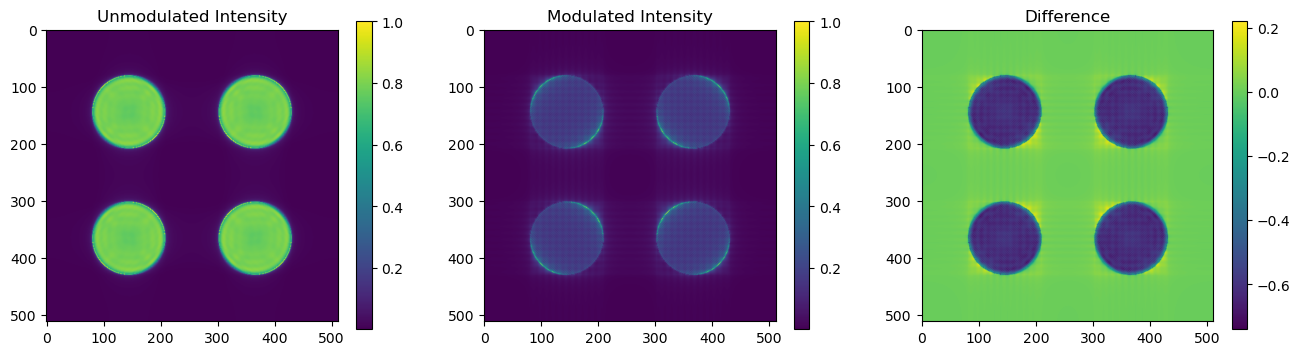

In [22]:
def modulate(input, alpha_pix):
    ny, nx = np.shape(input)
    cx, cy = nx // 2, ny // 2

    # Coordinates wrt center
    x = np.arange(nx) - cx
    y = np.arange(ny) - cy

    # X, Y = np.meshgrid(x, y)
    # tiltX = X/np.max(X)
    # tiltY = Y/np.max(Y) 
    tiltX, tiltY = np.meshgrid(x, y)

    intensity = np.zeros([ny,nx])

    N_steps = int((alpha_pix//4+1)*4)

    for i in range(N_steps):
        phi = np.pi*2/N_steps*i
        tilt = tiltX * np.cos(phi) + tiltY * np.sin(phi)
        # tilt = (tilt-np.mean(tilt))/np.std(tilt)
        tilted_input = input + np.exp(1j*tilt*alpha_pix)
        output = wfs.propagate(tilted_input,pix2rad)
        intensity += np.abs(output**2)/N_steps

    return intensity

diameter = 0.03
alpha = 3*lambdaInM/diameter
alpha_pix = alpha/pix2rad

modulated_intensity = modulate(input_field, alpha_pix)


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title("Unmodulated Intensity")
plt.imshow(intensity/np.max(intensity))
plt.colorbar(shrink=0.5)


plt.subplot(1,3,2)
plt.title("Modulated Intensity")
plt.imshow(modulated_intensity/np.max(modulated_intensity))
plt.colorbar(shrink=0.5)

plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(modulated_intensity/np.max(modulated_intensity)-intensity/np.max(intensity))
plt.colorbar(shrink=0.5)
